In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

In [2]:
cleaned_data = pd.read_csv("https://raw.githubusercontent.com/ryanbenner/CPSC392Final/main/Cleaned_Data_Fortune_1000.csv")
cleaned_data.dropna(inplace = True)
cleaned_data.reset_index(inplace = True)
row_count = len(cleaned_data)

print(f'The DataFrame has {row_count} rows.')
cleaned_data.head()

The DataFrame has 688 rows.


,index,rank,name,revenues,revenue_percent_change,profits,profits_percent_change,assets,market_value,change_in_rank,employees
0,0,1,Walmart,572754.0,2.4,13673.0,1.2,244860.0,409795.0,0.0,2300000.0
1,1,2,Amazon,469822.0,21.7,33364.0,56.4,420549.0,1658807.3,0.0,1608000.0
2,2,3,Apple,365817.0,33.3,94680.0,64.9,351002.0,2849537.6,0.0,154000.0
3,3,4,CVS Health,292111.0,8.7,7910.0,10.2,232999.0,132839.2,0.0,258000.0
4,4,5,UnitedHealth Group,287597.0,11.8,17285.0,12.2,212206.0,479830.3,0.0,350000.0


#**Q1**
##**Question:**
When predicting company profitability, which predictor has the biggest impact on profits? How does excluding certain predictors affect the model's accuracy in predicting profits?


##**Variables Involved:**
profits (continuous) - variable to be predicted, revenues (continuous), revenue_percent_change (continuous), profits_percent_change (continuous), assets (continuous), market_value (continuous), employees (continuous).


##**Cleaning:**
##Missing values will be dropped, and the variables rank, change_in_rank, and name may be excluded from the model as the likely will not have any impact on the model’s predictions


##**Modeling/Computation:**
Train/Test split with an 80/20 split will be used. Variables will be standardized with StandardScaler(). Several linear regression models will be fit: Individual models excluding one predictor at a time. The R² scores for both the train and test sets will be compared to determine the ‘weight’ of each predictor


##**Graphs:**
Bar charts comparing the R2 scores of train and test sets for each model
Scatter plot of most influential predictor variable versus profits


##**Brief Discussion of why analysis is effective at answering the question:**
This analysis method will allow me to independently test each of the predictor variables in order to determine which variable has the largest effect on a company’s profitability. This will work by allowing me to isolate one variable in each of the regression models fitted, and can provide a clear insight into the importance of each variable. The visualizations will allow me, and any reader, easy access to interpretation of the analysis results.


Excluding 'revenues':
MSE on training set:  11796155.722084923
MSE on testing set:  8918035.10052567


Excluding 'revenue_percent_change':
MSE on training set:  9491695.479951018
MSE on testing set:  10081090.524019483


Excluding 'profits_percent_change':
MSE on training set:  9489818.762411986
MSE on testing set:  10311945.373636775


Excluding 'assets':
MSE on training set:  13349298.629926292
MSE on testing set:  14085613.075015392


Excluding 'market_value':
MSE on training set:  19627342.431656543
MSE on testing set:  37027315.57745538


Excluding 'employees':
MSE on training set:  4102248.8028892567
MSE on testing set:  37946024.408540875




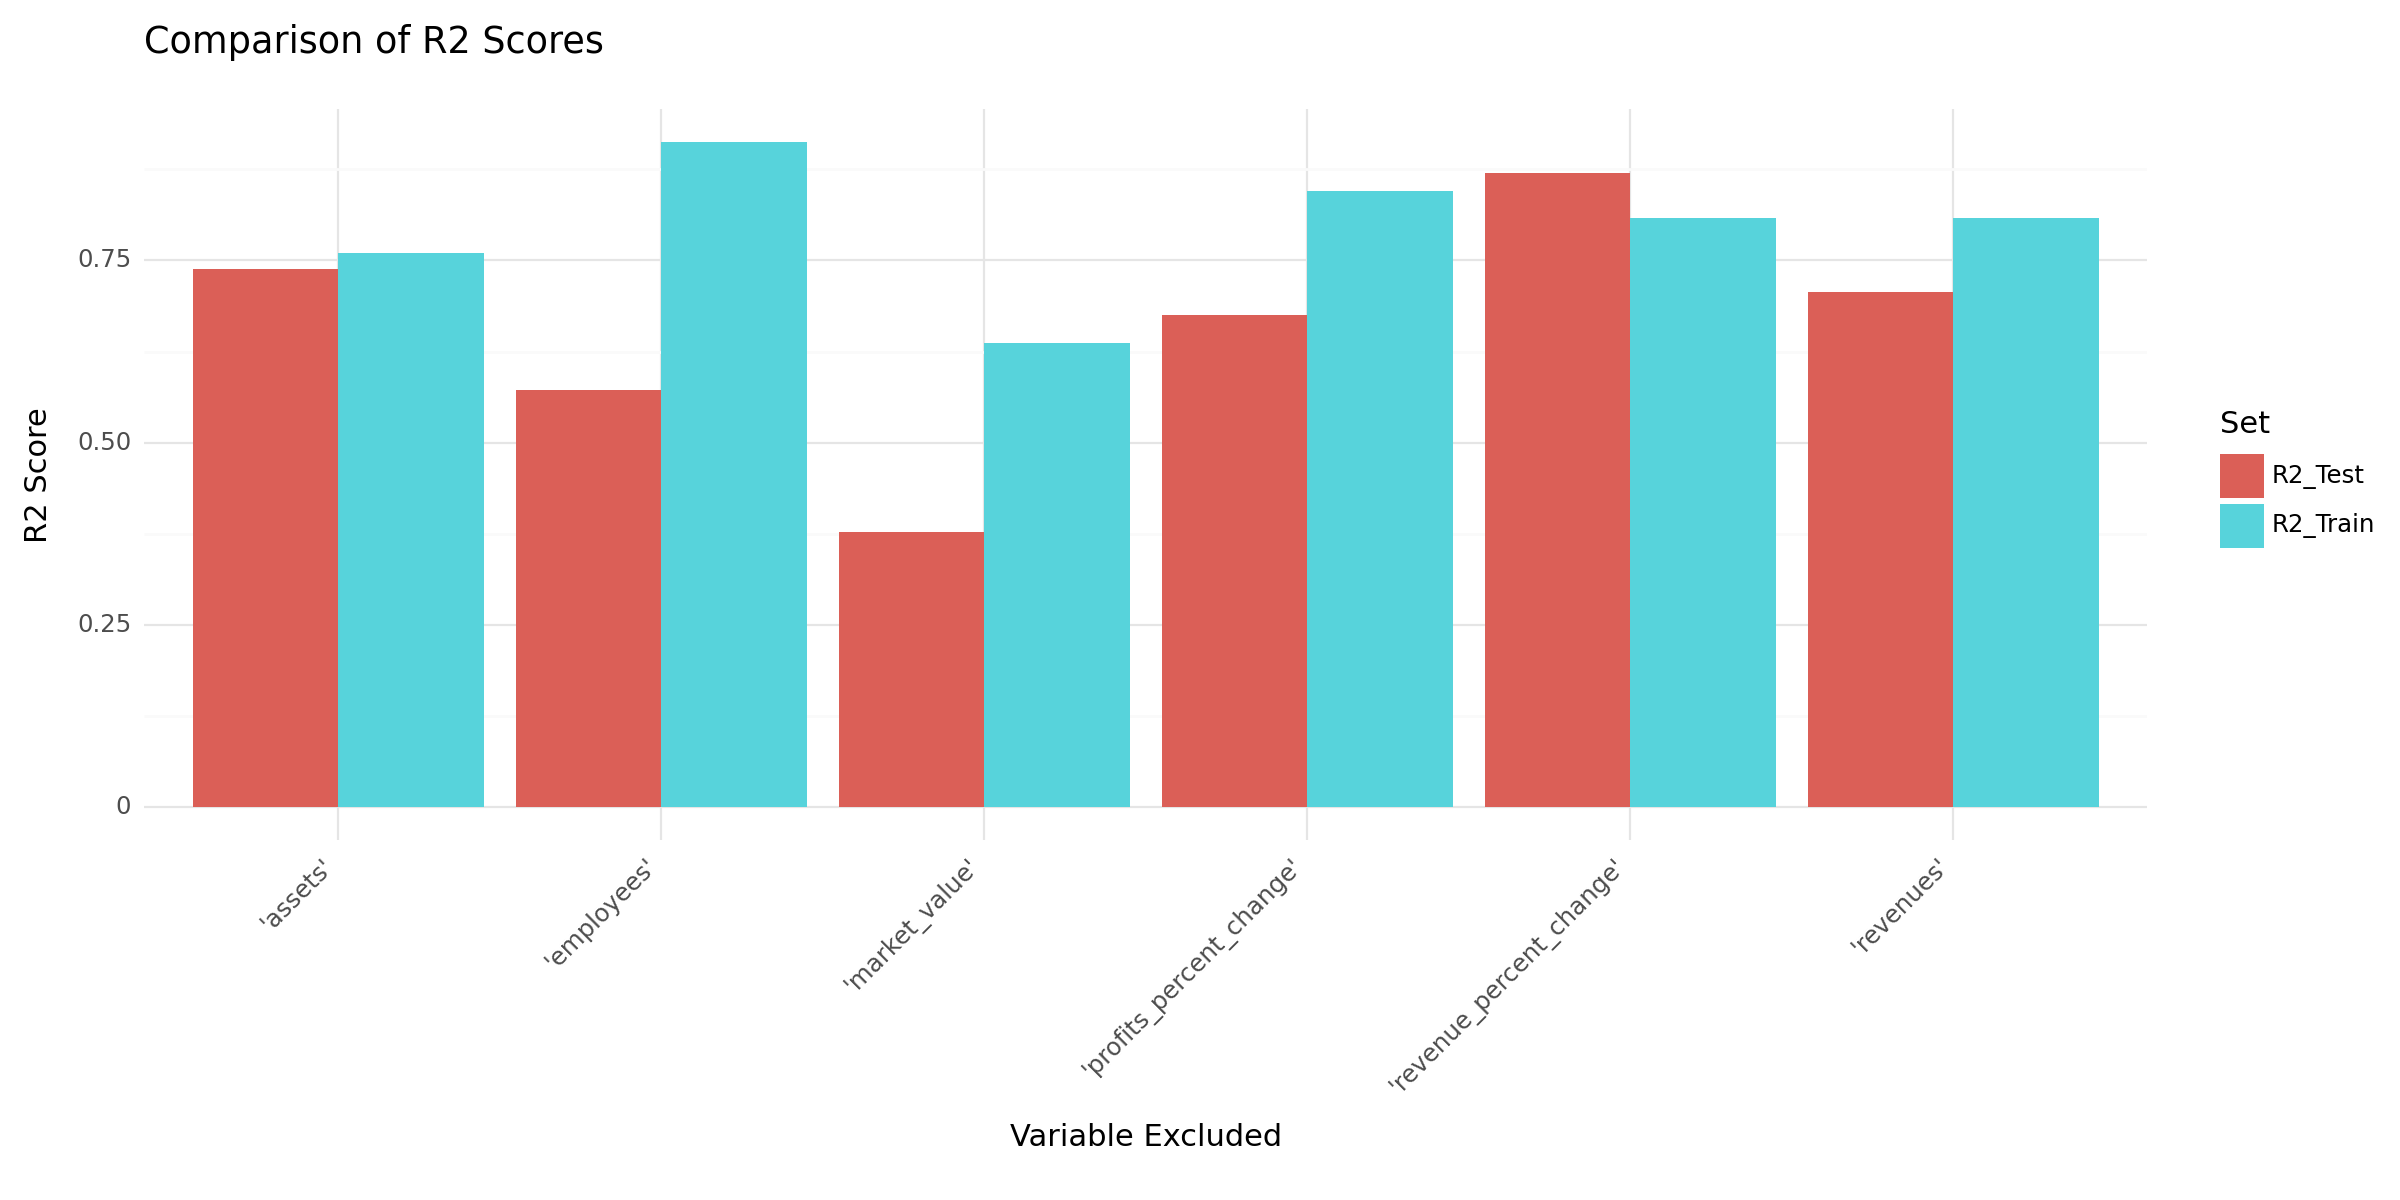

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/ryanbenner/CPSC392Final/main/Cleaned_Data_Fortune_1000.csv")
data.dropna(inplace = True)
data.reset_index(inplace = True)

predictors = ['revenues', 'revenue_percent_change', 'profits_percent_change', 'assets', 'market_value', 'employees']

y = data['profits']

r2_train_array = []
r2_test_array = []

for predictor in predictors:
    subset_predictors = [p for p in predictors if p != predictor]  # exclude current predictor

    X = data[subset_predictors]

    # Stores training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    # Z-score standardization setup
    z = make_column_transformer((StandardScaler(), subset_predictors),
                                remainder="passthrough")

    ridge = Ridge(alpha=1.0)
    pipe = Pipeline([("zscore", z),
                      ("ridge", ridge),
                    #  ("linearregression", lr)
                     ])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict on training and test data
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # Assess model performance
    print(f"Excluding '{predictor}':")
    print("MSE on training set: ", mean_squared_error(y_train, y_pred_train))
    print("MSE on testing set: ", mean_squared_error(y_test, y_pred_test))
    print("\n")  # Adds a newline for better spacing between outputs
    # add each iteration of r2 train to an array
    r2_train_array.append(r2_score(y_train, y_pred_train))
    r2_test_array.append(r2_score(y_test, y_pred_test))

results = {
'Model': ["'revenues'", "'revenue_percent_change'",
          "'profits_percent_change'", "'assets'",
          "'market_value'", "'employees'"],
'R2_Train': r2_train_array,
'R2_Test': r2_test_array
}

df = pd.DataFrame(results)
df_melted = df.melt(id_vars='Model', var_name='Set', value_name='R2_Score') # Found on https://pandas.pydata.org/docs/reference/api/pandas.melt.html

# Plotting
plot = (ggplot(df_melted, aes(x='Model', y='R2_Score', fill='Set')) +
        geom_bar(stat='identity', position='dodge') +
        labs(title='Comparison of R2 Scores', x='Variable Excluded', y='R2 Score') +
        theme_minimal() +
        theme(axis_text_x=element_text(rotation=45, hjust=1), # Found on https://stackoverflow.com/questions/1330989/rotating-and-spacing-axis-labels-in-ggplot2
              figure_size=(12, 6)))  # Increase the size
print(plot)

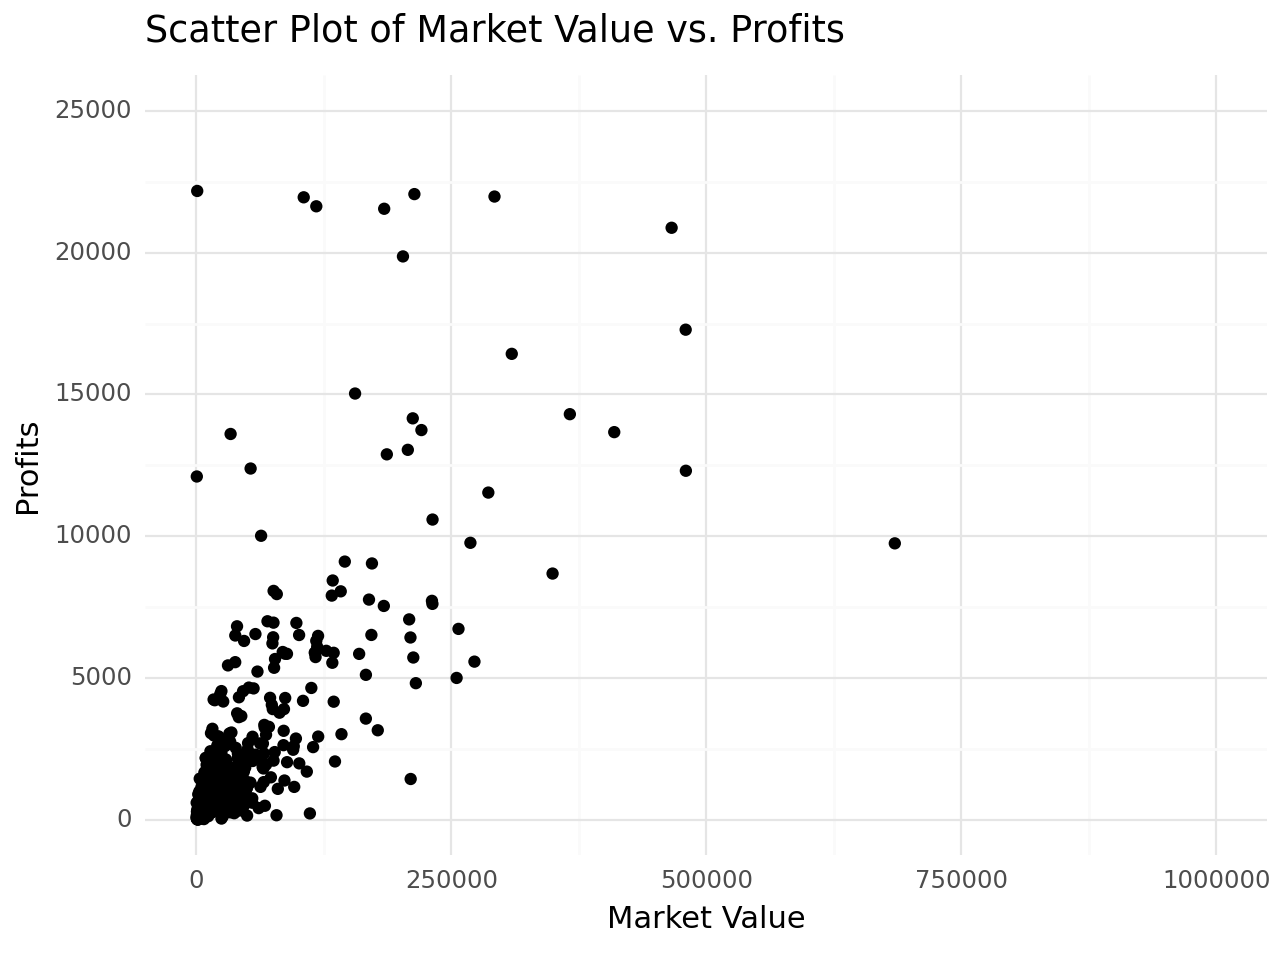

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/ryanbenner/CPSC392Final/main/Cleaned_Data_Fortune_1000.csv")
data.dropna(inplace = True)

data_frame = pd.DataFrame({
    'Market Value': data['market_value'],
    'Profits': data['profits']
})

# Plotting
scatter_plot = (ggplot(data_frame, aes(x='Market Value', y='Profits')) +
                geom_point() +
                labs(title='Scatter Plot of Market Value vs. Profits', x='Market Value', y='Profits') +
                theme_minimal() + xlim(0, 1000000) +  # Setting x-axis limit to 1,000,000, removes outliers
                ylim(0, 25000))
print(scatter_plot)


#**Q2**
##**Question:**
Can clustering methods identify groups of companies with similar properties based on revenues, profits, and assets? What are the common traits within each cluster of companies?


##**Variables Involved:**
revenues (continuous), profits (continuous), assets (continuous)


##**Cleaning:**
Data cleaning will involve dropping any missing values, as well as accounting for any outliers, as they can heavily skew an accurate clustering model


##**Modeling/Computation:**
Will need to standardize the data in order to generate more accurate clustering models, as clustering models are distance based, so the data needs to be normalized by StandardScaler() in order to make accurate clusters. Likely, a k-means clustering model will be used, although depending on the shapes of data during analysis, this could change to a Gaussian mixture model if the data is non-spherical. The optimal number of clusters will be determined during the analysis based on a metric such as the elbow method.


##**Graphs:**
Elbow Plot: A plot to show the sum of squared errors against the number of clusters to help identify the elbow point, which is a good indicator of the optimal number of clusters.
Cluster Plot: A scatter plot using PCA to reduce dimensions and visualize the clustering by plotting the first two principal components. This will help to visualize the structure within the clusters


##**Brief Discussion of why analysis is effective at answering the question:**
This clustering approach is effective because it will allow me to group companies into clusters based upon important financial metrics. By standardizing these metrics, the analysis will be able to reveal patterns within companies that lead to more successful companies. Additionally, it will help identify common themes across successful companies, and could help struggling or starting companies to follow these trends and potentially find similar success doing so. The graphs will help me both determine the optimal number of clusters, as well as help visualize the clusters in a strategic manner, which will be more interpretable.

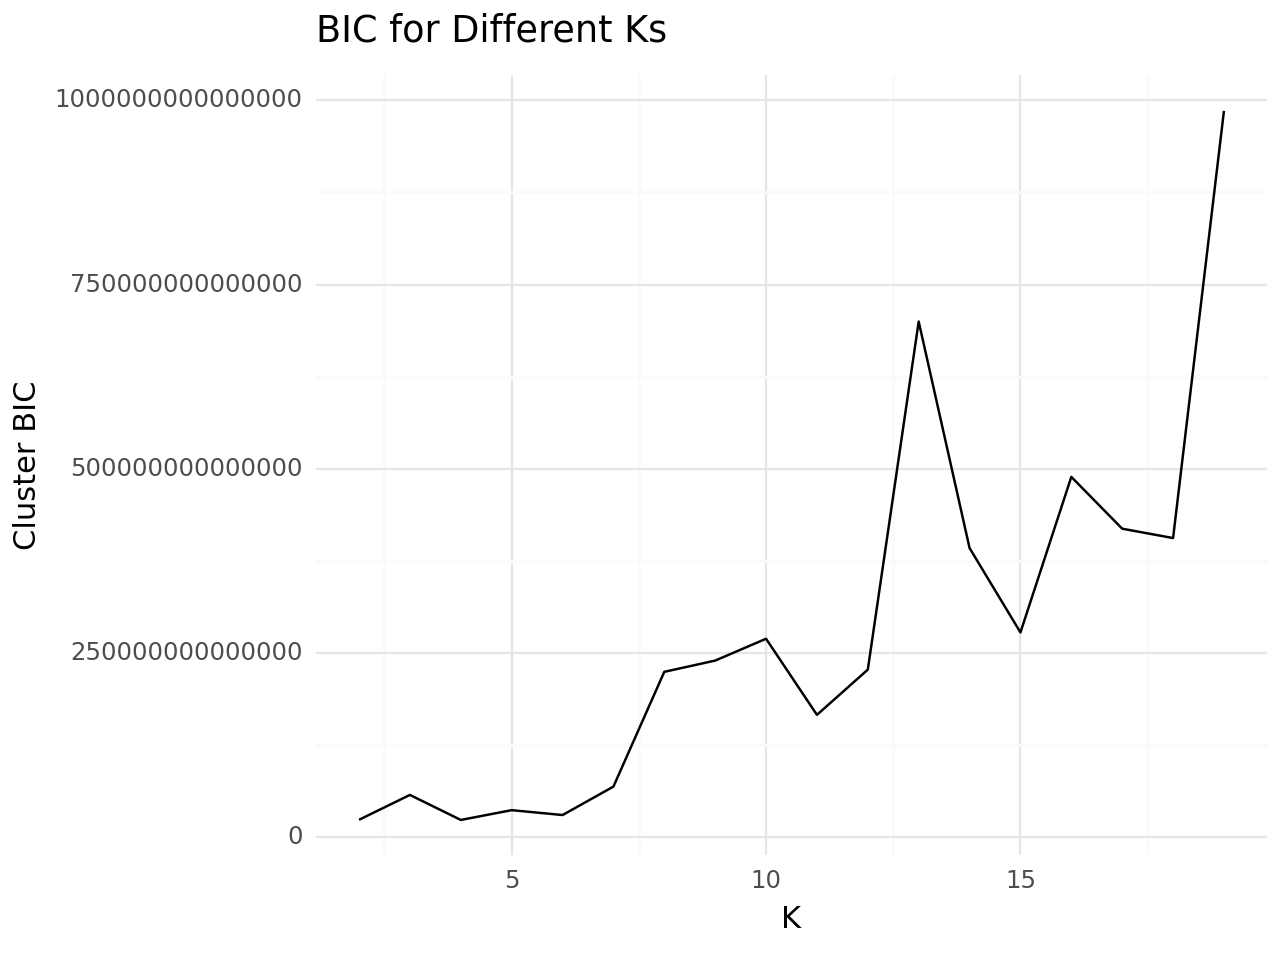

In [11]:
fortune = pd.read_csv("https://raw.githubusercontent.com/ryanbenner/CPSC392Final/main/Cleaned_Data_Fortune_1000.csv")
fortune.dropna(inplace=True)
fortune.reset_index(inplace=True)

predictors = ['revenues', 'profits', 'assets']

X = fortune[predictors]

z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

metrics = {"BIC": [], "k": []}

for i in range(2,20):
    gmm = GaussianMixture(i)
    pipe = Pipeline([
        ("pre", z),
        ("gmm", gmm)
    ])

    labels = pipe.fit_predict(X[predictors])
    bic_val = pipe.named_steps["gmm"].bic(X[predictors])

    metrics["BIC"].append(bic_val)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

print(ggplot(df, aes(x = "k", y = "BIC")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Cluster BIC",
         title = "BIC for Different Ks"))

Silhouette score: 0.8189861372287914


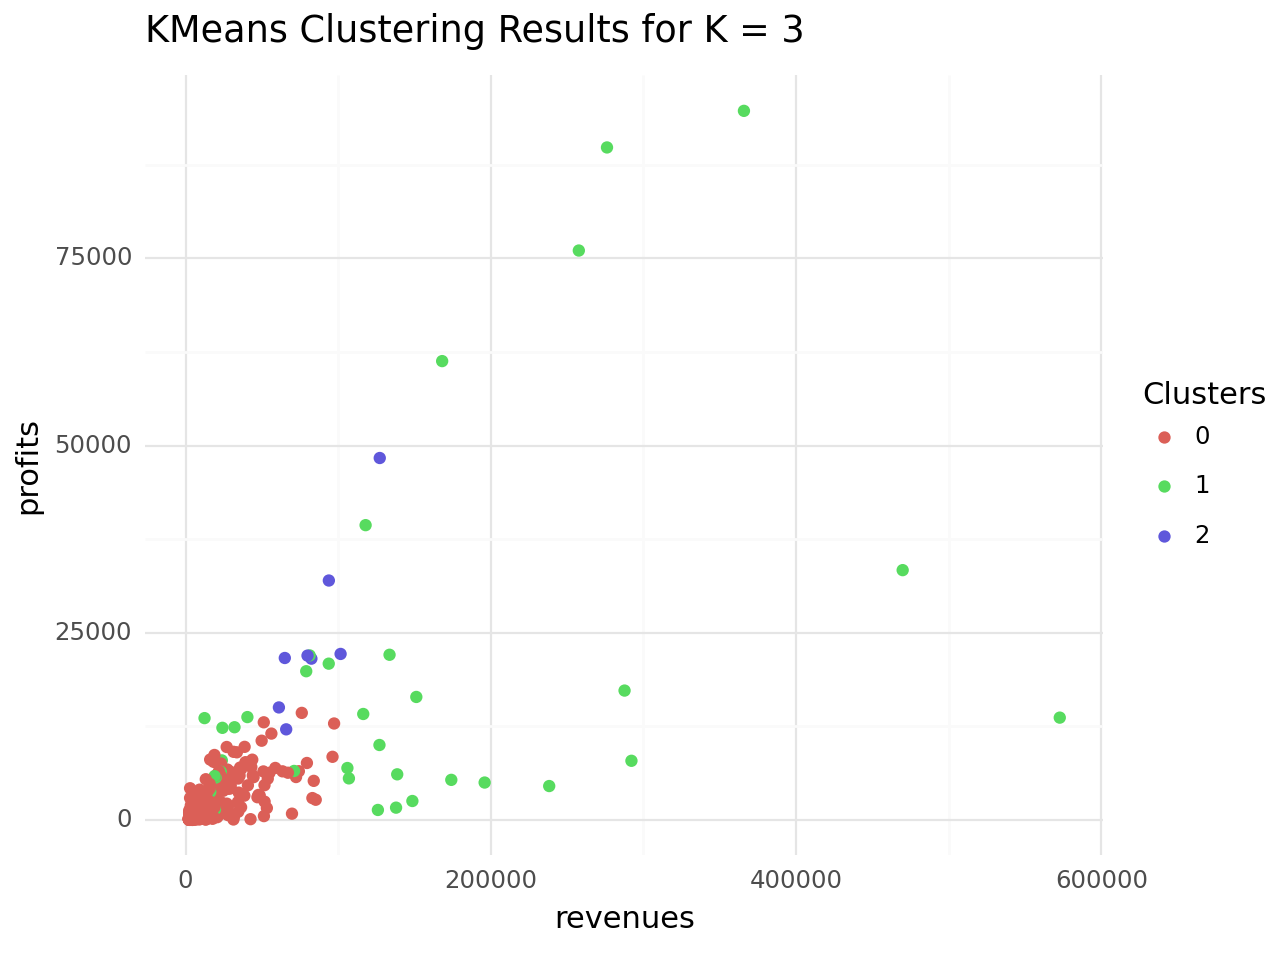

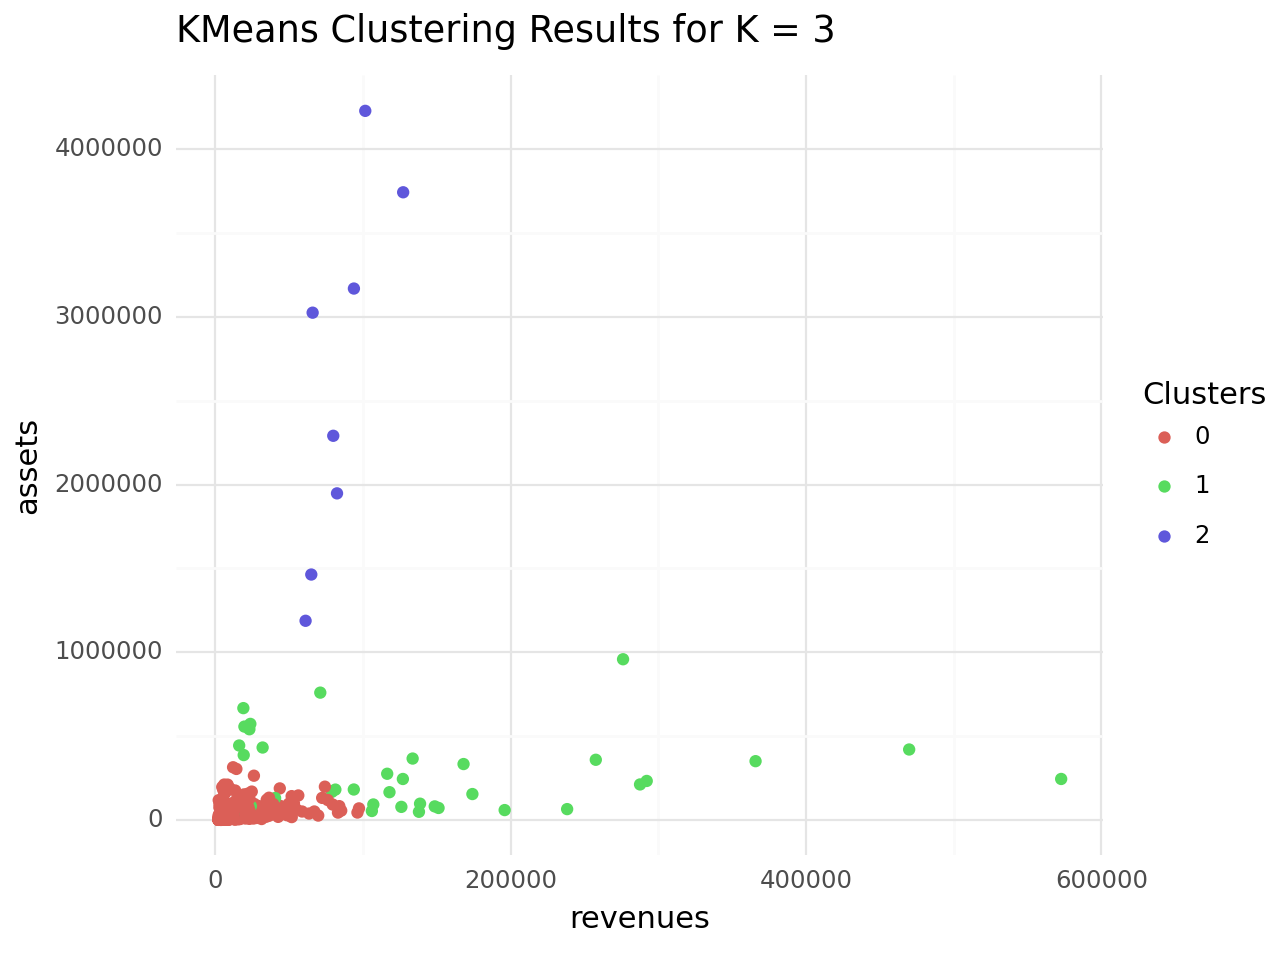

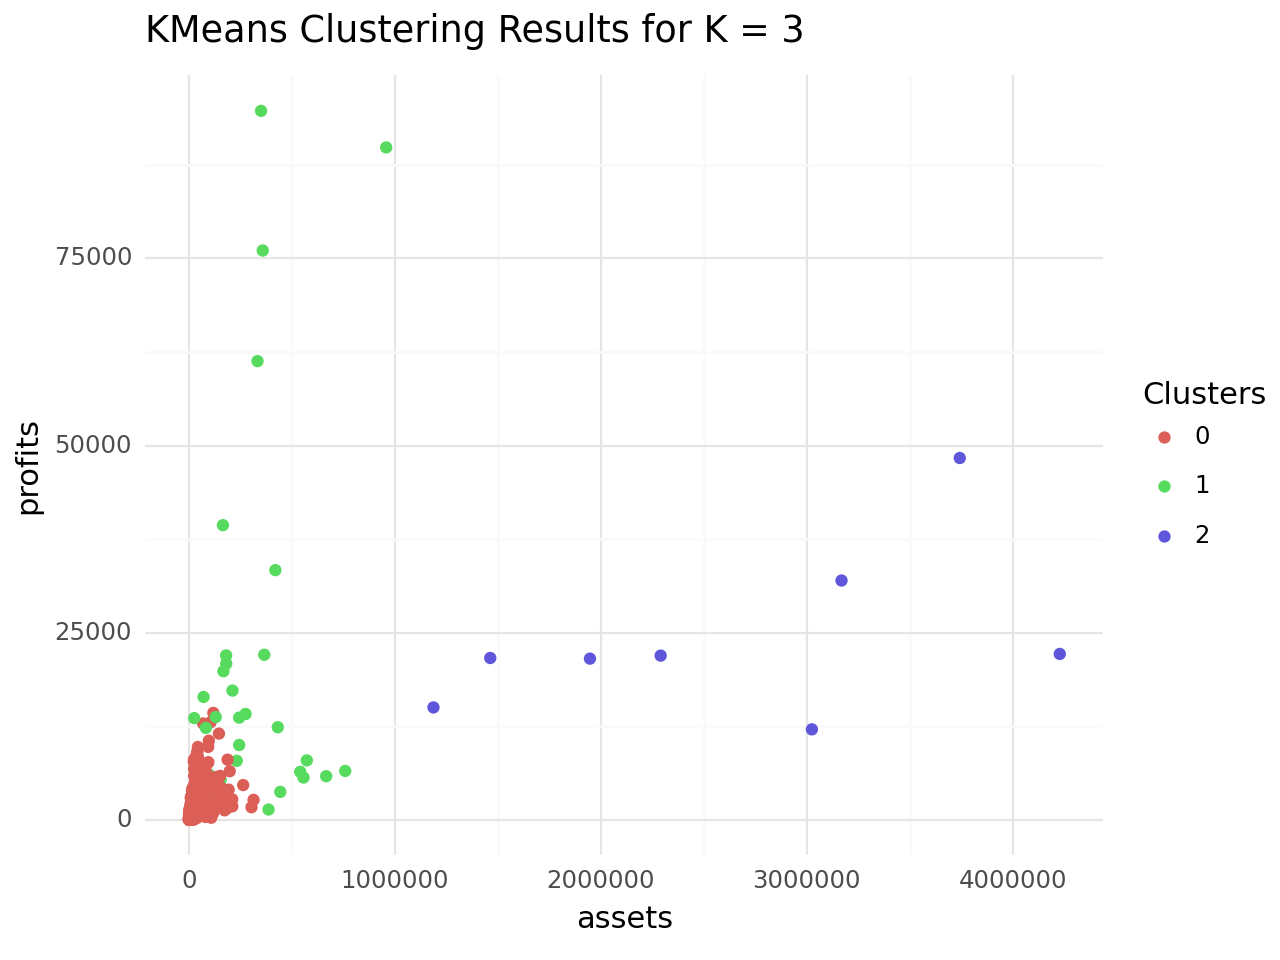

In [14]:
gmm = GaussianMixture(n_components= 3)
pipe = Pipeline([("z", z), ("clust", gmm)])

#### STEP 4. ####
labels = pipe.fit_predict(X)

#### STEP 5. ####
print(f"Silhouette score: {silhouette_score(X, pipe.predict(X))}")
X["clusters"] = labels

print(ggplot(X, aes(x = "revenues", y = "profits", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "revenues", y = "profits", title = "KMeans Clustering Results for K = 3",
         color = "Clusters"))
print(ggplot(X, aes(x = "revenues", y = "assets", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "revenues", y = "assets", title = "KMeans Clustering Results for K = 3",
         color = "Clusters"))
print(ggplot(X, aes(x = "assets", y = "profits", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "assets", y = "profits", title = "KMeans Clustering Results for K = 3",
         color = "Clusters"))

# Q6:
**Question:** In predicting profit margins, how effective is dimensionality reduction at reducing the number of variables needed to maintain a high level of accuracy? Which key components or variables are the most important in determining profit margins after reduction?

**Variables Involved:** revenues (continuous), profits (continuous), market_value (continuous), employees (continuous), revenue_percent_change (continuous), profits_percent_change (continuous), profit_margin(continuous)

**Cleaning:** Handle missing data by dropping those values, standardize the data to ensure it is normalized, and ensure outliers are acknowledged/dealt with, as they might affect model performance

## Modeling/Computation:

  **Dimensionality Reduction:** Use Principal Component Analysis (PCA) technique to reduce the number of variables. Find the key PCs or reduced set of variables that retain the majority of the variance in original data

  **Prediction:** Build linear regression model to predict profit margins using the reduced set of variables. Evaluate performance of model using metrics like R2, MAE, and MSE

**Feature Importance:** Analyze the components or variables to determine which are most influential in predicting profit margins

## Graphs:
**Cumulative Variance Plot:** A cumulative variance plot showing the explained variance for each principal component to help determine how many components are necessary to capture most of the original data(93%).

**Feature Importance Plot:** A bar chart or dot plot showing the importance of each variable or principal component in predicting profit margins. This plot highlights the key factors that affect profit margins.

## Analysis:

**Brief discussion of why analysis is effective at answering the question:** This analysis explores the question of determining whether PCA is an effective way to predict profit margins of a company. The scree plot is useful in determining the fewest number of components needed to effectively describe profit margins, while the feature importance plot allows a clear interpretation of which variables are most crucial to predict profits. This is similar to a previous model, but with the focus instead shifted to determining a company’s profitability.


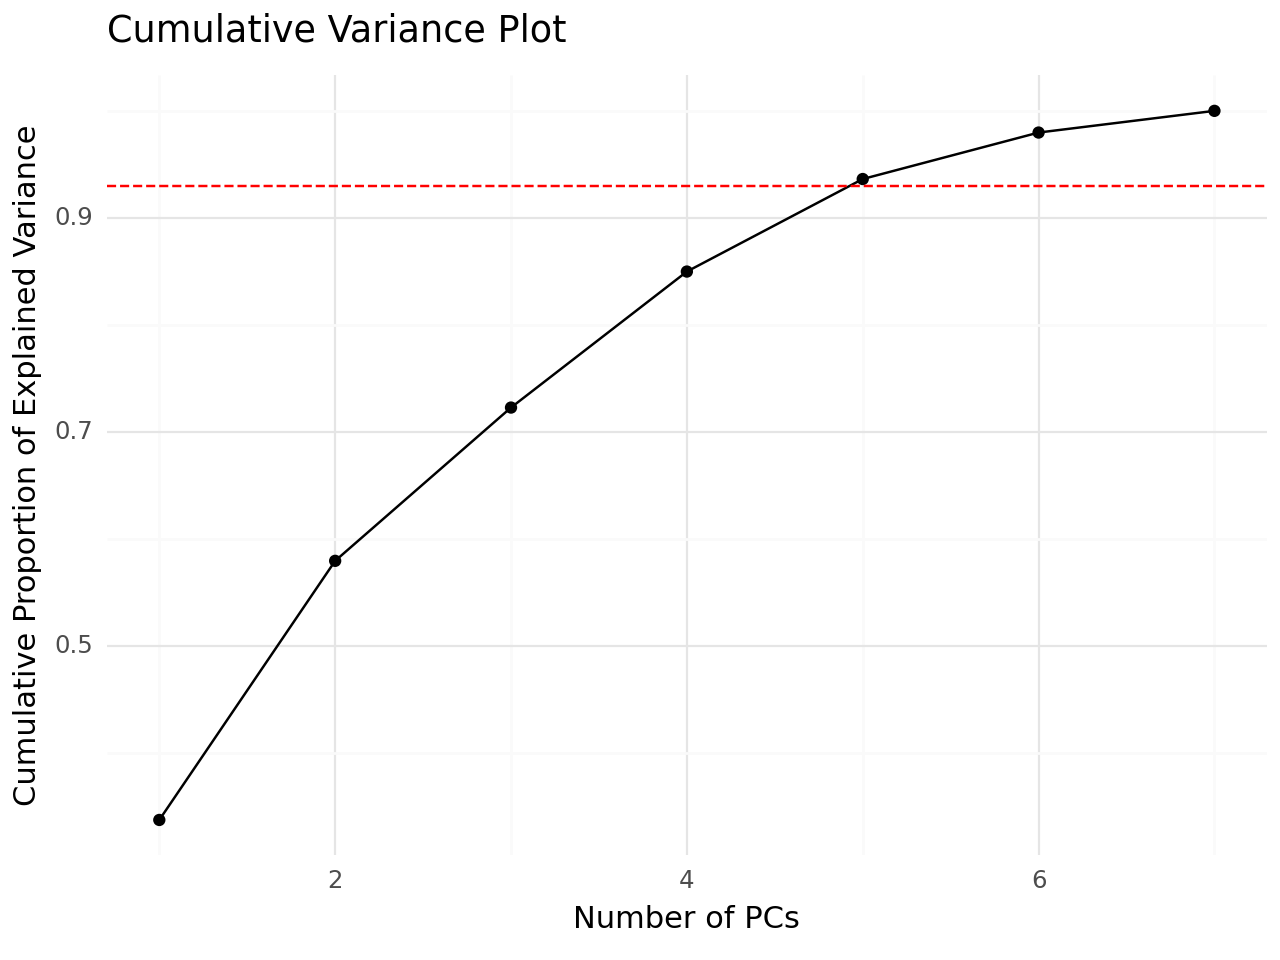

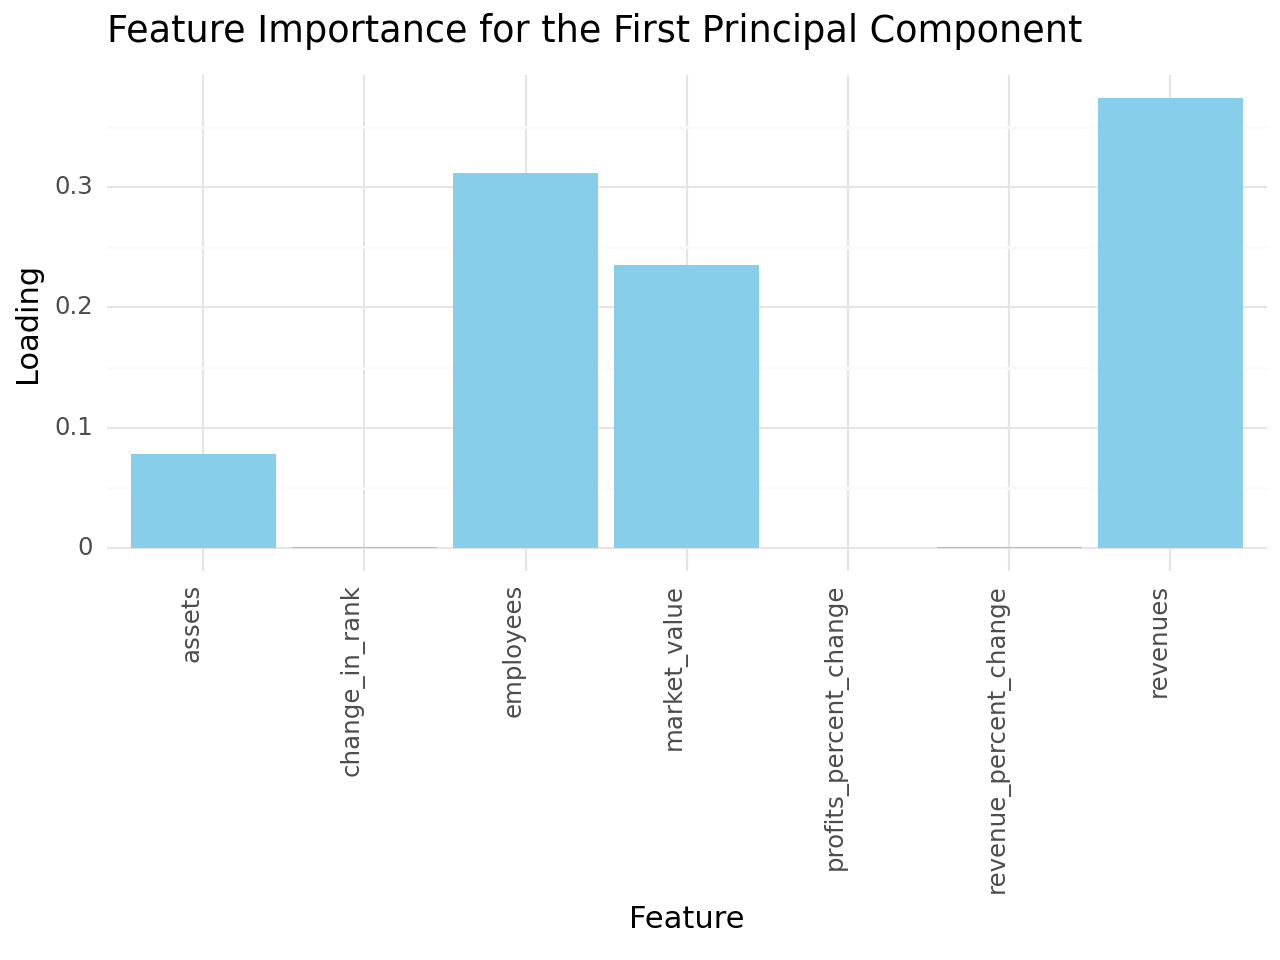

In [16]:
fortune = pd.read_csv("https://raw.githubusercontent.com/ryanbenner/CPSC392Final/main/Cleaned_Data_Fortune_1000.csv")
fortune.dropna(inplace=True)
fortune.reset_index(inplace=True)

predictors = ['revenues', 'revenue_percent_change', 'profits_percent_change', 'assets', 'market_value', 'change_in_rank', 'employees']

X = fortune[predictors]
y = fortune['profits']

# tts
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2)

# empty pipeline
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

pca = PCA()

pipe_pca = Pipeline([
    ("z", z),
    ("pca", pca)
])

# fit
pipe_pca.fit(X_train)

# cumvar plot
pcaDF = pd.DataFrame({"expl_var" :
                      pipe_pca.named_steps["pca"].explained_variance_ratio_,
                      "pc": range(1,8),
                      "cum_var":
                      pipe_pca.named_steps["pca"].explained_variance_ratio_.cumsum()})

print(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.93, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance", title = "Cumulative Variance Plot"))

loadings = pd.DataFrame({
    'Feature': predictors,
    'Loading': abs(pipe_pca.named_steps['pca'].components_[0])**2 ## square bc some are negative, makes them all on same scale / sum = 1
})

# Bar chart of feature importance for the first principal component
print(ggplot(loadings, aes(x='Feature', y='Loading')) +
    geom_bar(stat='identity', fill='skyblue') +
    theme_minimal() +
    labs(x='Feature', y='Loading', title='Feature Importance for the First Principal Component')
    + theme(axis_text_x=element_text(angle=90, hjust=1)))


In [17]:
# empty pipeline
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

pca = PCA(n_components = 5)

pipe_lr = Pipeline([
    ("z", z),
    ("pca", pca),
    ("model", LinearRegression())
])

# fit
pipe_lr.fit(X_train,y_train)

y_pred_train = pipe_lr.predict(X_train)
y_pred_test  = pipe_lr.predict(X_test)

y_pred_train_prob = pipe_lr.predict(X_train)
y_pred_test_prob  = pipe_lr.predict(X_test)

# assess
print(f"Train R2: {r2_score(y_train, y_pred_train)}")
print(f"Test R2: {r2_score(y_test, y_pred_test)}")

Train R2: 0.7443135476401492
Test R2: 0.963972950968834
